# Geotab Intersection Congestion Prediction

Intersection Congestion provides information gathered from commercial vehicle telematics devices.It includes aggregate stopped vehicle information and intersection wait times. 

Possible use cases include(Geotab website): 
1. A city can use the data to analyze congestion and light timing issues at scale across the region, and evaluate for impact or potential impact of infrastructure changes. 
2. NGOs can use the data as part of research into emissions and pollution. 
3. Fleet managers can use the information on traffic congestion at intersections as a factor to support optimal routing decisions.

In this project, we use intersection details of Philadelphia city. Aim of this project is to make use of the amazon sagemaker service to predict congesion by aggregate measure of stopping distance and waiting times. 

## Data Preparation and Preprocessing

**Importing neccessary Sagemaker packages & Loading data from s3 bucket**

In [1]:
import sagemaker
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import boto3
sm_boto3 = boto3.client('sagemaker')
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = sess.default_bucket()  # this could also be a hard-coded bucket name
print('Using bucket ' + bucket)

Using bucket sagemaker-us-east-1-125155160178


In [2]:
#Load train data from s3 bucket
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
buck_location = 'geotabsagemakrartifacts/traindata'
location_file = 'train.csv'
df_raw_train = pd.read_csv("s3://{}/{}".format(buck_location,location_file))
df_raw_train = df_raw_train[df_raw_train['City'] == 'Philadelphia']

In [67]:
# Make a copy of df_raw_train
df_train = df_raw_train.copy(deep=True)
print(df_train.shape)

(390237, 28)


In [68]:
# Print the first 10 rows of df_train
df_train.head(10)

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
466150,2387507,0,39.970787,-75.154152,West Girard Avenue,West Girard Avenue,E,E,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia
466151,2387508,0,39.970787,-75.154152,West Girard Avenue,West Girard Avenue,W,W,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia
466152,2387509,0,39.970787,-75.154152,West Girard Avenue,West Girard Avenue,E,E,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia
466153,2387510,0,39.970787,-75.154152,West Girard Avenue,West Girard Avenue,W,W,2,0,...,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,61.5,Philadelphia
466154,2387511,0,39.970787,-75.154152,West Girard Avenue,West Girard Avenue,E,E,20,0,...,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,56.7,Philadelphia
466155,2387512,0,39.970787,-75.154152,West Girard Avenue,West Girard Avenue,E,E,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia
466156,2387513,0,39.970787,-75.154152,West Girard Avenue,North 11th Street,W,N,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia
466157,2387514,0,39.970787,-75.154152,West Girard Avenue,West Girard Avenue,W,W,2,0,...,0.0,0.0,15.0,31.0,0.0,0.0,0.0,50.1,56.2,Philadelphia
466158,2387515,0,39.970787,-75.154152,West Girard Avenue,West Girard Avenue,W,W,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia
466159,2387516,0,39.970787,-75.154152,West Girard Avenue,West Girard Avenue,E,E,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia


**Splitting data - train set & test set for modelling**

In [69]:
from sklearn.model_selection import train_test_split
# Divide the training data into training (80%) and validation (20%) (using sklearn train_test_split with random_state=42)
df_train, df_test = train_test_split(df_train, train_size=0.8, random_state=42)
# Reset the index
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)
# Print the dimension of df_train
print("Train Data")
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

Train Data


,# rows,# columns
0,312189,28


In [70]:
# Print the dimension of df_valid
print("Test Data")
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

Test Data


,# rows,# columns
0,78048,28


In [71]:
# Combine df_train, df_valid and df_test
df = pd.concat([df_train, df_test], sort=False)

**Preprocess - Identifying & removing identifiers**

Column with only unique values has no effect on modell building, removing such columns from dataset

In [72]:
def id_checker(df):
    """
    The identifier checker

    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    The dataframe of identifiers
    """
    
    # Get the identifiers
    df_id = df[[var for var in df.columns 
                if df[var].nunique(dropna=True) == df[var].notnull().sum()]]
                
    return df_id

In [73]:
# Call id_checker on df
df_id = id_checker(df)

# Print the first 5 rows of df_id
df_id.head()

,RowId
0,2644717
1,2389450
2,2489164
3,2413727
4,2594362


In [74]:
# Remove the identifiers from df_train
df_train = df_train.drop(columns=df_id.columns)

# Remove the identifiers from df_valid
df_test = df_test.drop(columns=df_id.columns)

# Print the first 5 rows of df_train
df_train.head()

,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,...,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
0,1298,39.954841,-75.183276,Market Street,Market Street,W,S,22,0,8,...,0.0,20.0,30.0,51.0,0.0,0.0,31.8,38.4,43.2,Philadelphia
1,11,39.968772,-75.134436,Frankford Avenue,East Girard Avenue,S,E,23,0,8,...,75.0,77.0,96.0,114.0,67.8,69.5,69.6,70.7,187.7,Philadelphia
2,480,39.984840,-75.237240,Upland Way,Upland Way,W,W,17,0,6,...,35.0,35.0,41.0,43.0,0.0,59.8,59.8,72.9,119.2,Philadelphia
3,114,39.899131,-75.174831,South 11th Street,South Broad Street,W,W,14,1,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia
4,1041,39.961016,-75.144987,Spring Garden Street,Spring Garden Street,W,W,14,0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia


In [75]:
# Print the first 5 rows of df_test
df_test.head()

,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,...,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
0,241,39.955345,-75.163015,North Broad Street,North Broad Street,N,N,21,1,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia
1,1201,40.022971,-75.136934,Roosevelt Boulevard,Roosevelt Boulevard,W,SW,17,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia
2,822,40.031814,-75.105518,Adams Avenue,Adams Avenue,NW,NW,1,0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia
3,732,39.939285,-75.178243,South 21st Street,South 21st Street,S,S,15,0,10,...,33.0,34.0,40.0,65.0,65.5,77.2,86.5,92.8,118.2,Philadelphia
4,595,40.025823,-75.122135,Rising Sun Avenue,Rising Sun Avenue,NE,NE,16,0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia


In [76]:
# Combine df_train, df_valid and df_test
df = pd.concat([df_train, df_test], sort=False)

**Preprocessing - Removing Nan values in datasets**

In [77]:
def nan_checker(df):
    """
    The NaN checker

    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    The dataframe of variables with NaN, their proportion of NaN and dtype
    """
    
    # Get the variables with NaN, their proportion of NaN and dtype
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    
    # Sort df_nan in accending order of the proportion of NaN
    df_nan = df_nan.sort_values(by='proportion', ascending=False)
    
    return df_nan

In [78]:
# Call nan_checker on df
df_nan = nan_checker(df)

# Print df_nan
df_nan.reset_index(drop=True)

,var,proportion,dtype
0,EntryStreetName,0.00768,object
1,ExitStreetName,0.00411,object


In [79]:
# Print the unique dtype of the variables with NaN
pd.DataFrame(df_nan['dtype'].unique(), columns=['dtype'])

,dtype
0,object


In [80]:
# Get the variables with missing values, their proportion of missing values and dtype
df_miss = df_nan[df_nan['dtype'] == 'object']

# Print df_miss
df_miss.reset_index(drop=True)

,var,proportion,dtype
0,EntryStreetName,0.00768,object
1,ExitStreetName,0.00411,object


In [81]:
import numpy as np

# Remove rows with missing values from df_train
df_train = df_train.dropna(subset=np.intersect1d(df_miss['var'], 
                                                 df_train.columns),
                           inplace=False)

# Remove rows with missing values from df_valid
df_test = df_test.dropna(subset=np.intersect1d(df_miss['var'], 
                                                 df_test.columns),
                           inplace=False)

In [18]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,308629,27


In [19]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,77125,27


In [20]:
# Combine df_train, df_valid and df_test
df = pd.concat([df_train, df_test], sort=False)

**Preprocessing - Handling Categorical Features**

From Dataset, Features are mostly categorical values and they are nominal data. Inorder reduce the dimensionality of final dataset and preserve information present in each feature, we are clustering regions and forming new feature.

Sagemaker provides various flexibility for building & deploying model in cloud. We can either build model in sagemaker and deploy the model or bring pre built model , use sagemaker service to deploy model for users access. 

In this project, we intend to experiment both these possibility using sagemaker. 

For building model, Sagemaker offers three ways 

1. Built in algorithmns
2. Open source pre-written containers(sklearn, pytorch, tensorflow, keras)
3. Bring own container & excute model in script mode

## Amazon Sagemaker in-built libraries

monthly free tier - First two months first sagemaker resources

- Building Model - 250 hours of t2.medium or t3.medium notebook usage 
- Training Model - 50 hours of m4.xlarge or m5.xlarge 
- Deploying Model - 125 hours of m4.xlarge or m5.xlarge 

In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, init='k-means++')
# fitting the k means algorithm on scaled data
kmeans.fit(df[['Latitude','Longitude']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
#To get ideal number of cluster based on elbow curve
import matplotlib.pyplot as plt
dist = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(df[['Latitude','Longitude']])
    dist.append(kmeans.inertia_)
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'dist':dist})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['dist'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

<Figure size 1200x600 with 1 Axes>

### Sagemaker - buildin library - KMeans Clustering

In [23]:
from sagemaker import KMeans
buck_location = 'geotabsagemakrartifacts/traindata'
output_location = "s3://{}".format(buck_location)
kmeans = KMeans(role=get_execution_role(),
train_instance_count=2,
train_instance_type='ml.m4.xlarge',
output_path=output_location,
k=10,data_location = output_location)
# fitting the k means algorithm
fit_data = (np.array(df[['Latitude','Longitude']])).astype('float32')
kmeans.fit(kmeans.record_set(fit_data))

2020-04-15 17:10:50 Starting - Starting the training job......
2020-04-15 17:11:22 Starting - Launching requested ML instances......
2020-04-15 17:12:26 Starting - Preparing the instances for training.........
2020-04-15 17:14:20 Downloading - Downloading input data
2020-04-15 17:14:20 Training - Downloading the training image...
2020-04-15 17:14:51 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/15/2020 17:14:42 INFO 140481424574272] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': 

### Deploying the Model

In [24]:
# Deploy my estimator to a SageMaker Endpoint and get a Predictor
predictor_km = kmeans.deploy(instance_type='ml.m4.xlarge',
                                     initial_instance_count=1)



---------------!

### Demo - Clustering

In [102]:
df[['Latitude','Longitude']].iloc[:10]

,Latitude,Longitude
0,39.954841,-75.183276
1,39.968772,-75.134436
2,39.984840,-75.237240
3,39.899131,-75.174831
4,39.961016,-75.144987
5,39.951526,-75.156736
6,39.891940,-75.241872
7,39.938268,-75.170009
8,39.924613,-75.181434
9,39.977303,-75.226953


In [103]:
#Take Sample latitude & longitude
sample = (np.array(df[['Latitude','Longitude']].iloc[:10])).astype('float32')
pred_sam = predictor_km.predict(sample)
clus_sam = [each.label['closest_cluster'].float32_tensor.values[0] for each in pred_sam]
clus_sam

[3.0, 8.0, 0.0, 6.0, 8.0, 1.0, 7.0, 1.0, 6.0, 0.0]

In [25]:
pred = []
pred1 = predictor_km.predict(fit_data[:150000])
pred.extend(pred1)
pred2 = predictor_km.predict(fit_data[150000:300000])
pred.extend(pred2)
pred3 = predictor_km.predict(fit_data[300000:])
pred.extend(pred3)

In [26]:
clus = [each.label['closest_cluster'].float32_tensor.values[0] for each in pred]
df['Cluster'] = clus
df.tail()

,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,...,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,Cluster
78043,192,39.955604,-75.189493,Market Street,North 33rd Street,W,N,21,0,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,3.0
78044,75,39.890379,-75.244999,Bartram Avenue,Bartram Avenue,NE,NE,16,1,6,...,0.0,0.0,17.0,0.0,0.0,0.0,0.0,52.4,Philadelphia,7.0
78045,1278,40.026936,-75.117317,C Street,C Street,S,S,17,0,12,...,94.0,109.0,133.0,32.2,96.3,125.9,147.2,242.0,Philadelphia,2.0
78046,360,39.959198,-75.175542,North 22nd Street,North 22nd Street,N,N,18,1,12,...,0.0,0.0,26.0,0.0,0.0,0.0,0.0,53.9,Philadelphia,3.0
78047,1906,39.934723,-75.152336,Washington Avenue,South 5th Street,E,N,14,0,10,...,15.0,41.0,54.0,0.0,0.0,38.8,53.9,56.2,Philadelphia,1.0


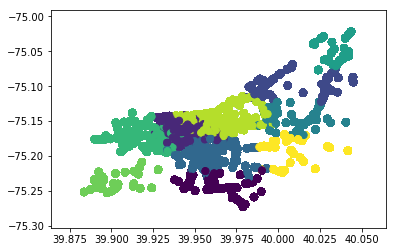

In [27]:
lat_lon = pd.DataFrame(df[['Latitude','Longitude']])
lat_lon['Cluster'] = clus
plt.scatter(lat_lon['Latitude'], lat_lon['Longitude'], c=clus, s=50, cmap='viridis')

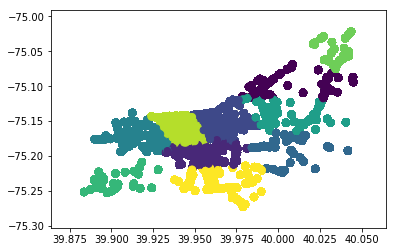

In [25]:
'''
# k means using 5 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters = 10, init='k-means++')
kmeans.fit(df[['Latitude','Longitude']])
pred = kmeans.predict(df[['Latitude','Longitude']])
lat_lon = pd.DataFrame(df[['Latitude','Longitude']])
lat_lon['Cluster'] = pred
plt.scatter(lat_lon['Latitude'], lat_lon['Longitude'], c=pred, s=50, cmap='viridis')
'''

**New Flag when Entry street name & exit street name**

As Entry street name & exit street name is category, inorder preserve those information keeping in mind on dimensionality of the dataset, we forming new feature called same_direction flag- 1- if entry and exit street are same , 0 otherwise. 

In [28]:
#Flag to identify vehicle is heading to same street
def same_direc(EntryStreetName,ExitStreetName):
    if EntryStreetName == ExitStreetName:
        return 1
    else:
        return 0

In [29]:
df['same_dire_flag'] = df.apply(lambda x: same_direc(x['EntryStreetName'],x['ExitStreetName']), axis = 1)
df.head()

,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,...,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,Cluster,same_dire_flag
0,1298,39.954841,-75.183276,Market Street,Market Street,W,S,22,0,8,...,30.0,51.0,0.0,0.0,31.8,38.4,43.2,Philadelphia,3.0,1
1,11,39.968772,-75.134436,Frankford Avenue,East Girard Avenue,S,E,23,0,8,...,96.0,114.0,67.8,69.5,69.6,70.7,187.7,Philadelphia,8.0,0
2,480,39.984840,-75.237240,Upland Way,Upland Way,W,W,17,0,6,...,41.0,43.0,0.0,59.8,59.8,72.9,119.2,Philadelphia,0.0,1
3,114,39.899131,-75.174831,South 11th Street,South Broad Street,W,W,14,1,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,6.0,0
4,1041,39.961016,-75.144987,Spring Garden Street,Spring Garden Street,W,W,14,0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,8.0,1


**New Feature - Direction**

In [30]:
#Directions condition
dirc_right = {'N' : ['SE','E','NE'],'E':['S','SW','SE'], 'S':['W','SW','NW'], 'W':['N','NW','NE'], 'NE': ['S','SE','E'], 'SW': ['W','NW','N'],'NW':['N','E','NE'],'SE':['S','SW','W']}
dirc_left = {'N' : ['SW','W','NW']  ,'E': ['NW','NE','N'] , 'S':['SE','NE','E'] , 'W': ['S','SW','SE'], 'NE': ['W','NW','N'] , 'SE': ['E','N','NE'] ,'SW': ['S','SE','E'],'NW':['S','W','SW']}
dirc_uturn = {'N' : 'S','S':'N','E':'W','W':'E','NW':'SE','SE':'NW','NE':'SW','SW':'NE'}

In [31]:
def direction(EntryHeading,ExitHeading):
    if EntryHeading == ExitHeading:
        return "Straight"
    elif ExitHeading in dirc_right[EntryHeading]:
        return "Right"
    elif ExitHeading in dirc_left[EntryHeading]:
        return "Left"
    elif ExitHeading in dirc_uturn[EntryHeading]:
        return "UTurn"

In [32]:
df['Direction'] = df.apply(lambda x: direction(x['EntryHeading'],x['ExitHeading']), axis = 1)
df.head()

,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,...,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,Cluster,same_dire_flag,Direction
0,1298,39.954841,-75.183276,Market Street,Market Street,W,S,22,0,8,...,51.0,0.0,0.0,31.8,38.4,43.2,Philadelphia,3.0,1,Left
1,11,39.968772,-75.134436,Frankford Avenue,East Girard Avenue,S,E,23,0,8,...,114.0,67.8,69.5,69.6,70.7,187.7,Philadelphia,8.0,0,Left
2,480,39.984840,-75.237240,Upland Way,Upland Way,W,W,17,0,6,...,43.0,0.0,59.8,59.8,72.9,119.2,Philadelphia,0.0,1,Straight
3,114,39.899131,-75.174831,South 11th Street,South Broad Street,W,W,14,1,9,...,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,6.0,0,Straight
4,1041,39.961016,-75.144987,Spring Garden Street,Spring Garden Street,W,W,14,0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,8.0,1,Straight


**New Feature - Road Type of heading street**

In [33]:
def road_type(Street_name):
    if ' Street' in Street_name:
        return "Street"
    elif ' St' in Street_name:
        return "Street"
    elif ' Avenue' in Street_name:
        return "Avenue"
    elif ' Ave' in Street_name:
        return "Avenue"
    elif ' Boulevard' in Street_name:
        return "Boulevard"
    elif 'Road' in Street_name:
        return "Road"
    elif 'Drive' in Street_name:
        return "Drive"
    elif 'Lane' in Street_name:
        return "Lane"
    elif 'Tunnel'  in Street_name:
        return "Tunnel"
    elif 'Highway' in Street_name:
        return "Highway"
    elif 'Parkway' in Street_name:
        return "Parkway"
    elif 'Parking' in Street_name:
        return "Parking"
    elif ' Bridge' in Street_name:
        return "Bridge"
    else: 
        return "Street"

In [34]:
df['Entry_Road_type'] = df.apply(lambda x: road_type(x['EntryStreetName']), axis = 1)
df['Exit_Road_type'] = df.apply(lambda x: road_type(x['ExitStreetName']), axis = 1)
df.head()

,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,...,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,Cluster,same_dire_flag,Direction,Entry_Road_type,Exit_Road_type
0,1298,39.954841,-75.183276,Market Street,Market Street,W,S,22,0,8,...,0.0,31.8,38.4,43.2,Philadelphia,3.0,1,Left,Street,Street
1,11,39.968772,-75.134436,Frankford Avenue,East Girard Avenue,S,E,23,0,8,...,69.5,69.6,70.7,187.7,Philadelphia,8.0,0,Left,Avenue,Avenue
2,480,39.984840,-75.237240,Upland Way,Upland Way,W,W,17,0,6,...,59.8,59.8,72.9,119.2,Philadelphia,0.0,1,Straight,Street,Street
3,114,39.899131,-75.174831,South 11th Street,South Broad Street,W,W,14,1,9,...,0.0,0.0,0.0,0.0,Philadelphia,6.0,0,Straight,Street,Street
4,1041,39.961016,-75.144987,Spring Garden Street,Spring Garden Street,W,W,14,0,12,...,0.0,0.0,0.0,0.0,Philadelphia,8.0,1,Straight,Street,Street


In [35]:
Final_Df = df.copy(deep=True)

In [36]:
#Filtering need features from original dataset
Final_Df = Final_Df[[ 'IntersectionId','Hour', 'Weekend',
       'Month', 'TotalTimeStopped_p80',
       'DistanceToFirstStop_p80', 'Cluster',
       'same_dire_flag', 'Entry_Road_type', 'Exit_Road_type','EntryHeading', 'ExitHeading']]

**Feature Encoder**

In [37]:
train = pd.get_dummies(Final_Df, columns=[ 'Hour', 'Month',
       'Weekend','Entry_Road_type', 'Exit_Road_type','EntryHeading', 'ExitHeading'])

In [38]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
train['IntersectionId'] = enc.fit_transform(train['IntersectionId'])

In [39]:
from sklearn.model_selection import train_test_split

target = [
       'DistanceToFirstStop_p80', 
       'TotalTimeStopped_p80']

df_train,df_test =  train_test_split(train, train_size=0.8, random_state=42)

# Reset the index
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)
#Save the train input
df_train.to_csv("df_train.csv")


In [40]:
import numpy as np
X_train_col = np.setdiff1d(df_train.columns, [ 
       'DistanceToFirstStop_p80', 
       'TotalTimeStopped_p80'] )
y_train = df_train[[
       'DistanceToFirstStop_p80', 
       'TotalTimeStopped_p80']]
X_train = df_train[X_train_col]

In [41]:
X_test = df_test[X_train_col]
y_test = df_test[[
       'DistanceToFirstStop_p80', 
       'TotalTimeStopped_p80']]

### Sagemaker **Using sklearn containers**

In [42]:
#Multioutput regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
max_depth=max_depth,
random_state=0, min_samples_split = 20))
regr_multirf.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
           n_jobs=None)

In [101]:
Feature_importance = pd.DataFrame()
Feature_importance['Features'] = X_train.columns
Feature_importance['Importance'] = regr_multirf.estimators_[0].feature_importances_
Feature_importance = Feature_importance.sort_values(ascending=False, by='Importance').reset_index(drop=True)
Feature_importance.head(5)

,Features,Importance
0,IntersectionId,0.496322
1,Cluster,0.082729
2,EntryHeading_E,0.034656
3,EntryHeading_W,0.030519
4,EntryHeading_SW,0.027710


In [43]:
#Save the Model for Future use
from sklearn.externals import joblib
import os
joblib.dump(regr_multirf, "regr_multirfc.joblib")
'''
from zipfile import ZipFile
# create a ZipFile object
zipObj = ZipFile('model_mtr.zip', 'w')
zipObj.write('regr_multirf.joblib')
# close the Zip File
zipObj.close()
'''
import tarfile
fileadd = tarfile.open('model.tar.gz','w:gz')
fileadd.add('regr_multirfc.joblib')
fileadd.close()
#Upload the file to S3 bucket
bucket_s3 = "geotabsagemakrartifacts"
sess.upload_data(
    path='model.tar.gz', bucket=bucket_s3,
    )


's3://geotabsagemakrartifacts/data/model.tar.gz'

## Amazon Sagemaker - Loading pre-trained model

In [ ]:
from sagemaker import s3
down_load = s3.S3Downloader()
file = "data/model.tar.gz"
down_load.download("s3://{}/{}".format(bucket_s3,file),".")
tar = tarfile.open("model.tar.gz", "r:gz")
tar.extractall()
tar.close()
rgr_mtr = joblib.load("regr_multirfc.joblib")

## Amazon Sagemaker - Script mode - Own container

In [47]:
from sagemaker.sklearn.estimator import SKLearn
#Path to train data
trainpath = sess.upload_data(
    path='df_train.csv', bucket=bucket,
    )
sklearn_estimator = SKLearn('sklearn-train.py',
                            role = get_execution_role(),
                            train_instance_type='ml.m4.xlarge',
                            framework_version='0.20.0',hyperparameters = {'min_samples_leaf':1,'target': 'DistanceToFirstStop_p80'})
sklearn_estimator.fit({'train':trainpath })

2020-04-15 18:06:35 Starting - Starting the training job...
2020-04-15 18:06:37 Starting - Launching requested ML instances......
2020-04-15 18:07:43 Starting - Preparing the instances for training.........
2020-04-15 18:09:32 Downloading - Downloading input data
2020-04-15 18:09:32 Training - Downloading the training image...
2020-04-15 18:09:52 Training - Training image download completed. Training in progress.2020-04-15 18:09:53,054 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-04-15 18:09:53,057 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-15 18:09:53,069 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-04-15 18:09:53,387 sagemaker-containers INFO     Module sklearn-train does not provide a setup.py. 
Generating setup.py
2020-04-15 18:09:53,387 sagemaker-containers INFO     Generating setup.cfg
2020-04-15 18:09:53,387 sagemaker-containers INFO     Generating MANIFES

## Deploy the Model 

In [48]:
# Deploy my estimator to a SageMaker Endpoint and get a Predictor
predictor_rf = sklearn_estimator.deploy(instance_type='ml.m4.xlarge',
                                     initial_instance_count=1)


---------------!

### Demo - Test Data Samples

In [104]:
#Loading Test Dataset from S3
buck_location_S3 = 'geotabsagemakrartifacts/data'
location_file_raw = 'df_test_raw.csv'
df_raw_test = pd.read_csv("s3://{}/{}".format(buck_location_S3,location_file_raw))
df_raw_test.head()

,Unnamed: 0,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
0,0,241,39.955345,-75.163015,North Broad Street,North Broad Street,N,N,21,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia
1,1,1201,40.022971,-75.136934,Roosevelt Boulevard,Roosevelt Boulevard,W,SW,17,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia
2,2,822,40.031814,-75.105518,Adams Avenue,Adams Avenue,NW,NW,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia
3,3,732,39.939285,-75.178243,South 21st Street,South 21st Street,S,S,15,0,...,33.0,34.0,40.0,65.0,65.5,77.2,86.5,92.8,118.2,Philadelphia
4,4,595,40.025823,-75.122135,Rising Sun Avenue,Rising Sun Avenue,NE,NE,16,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia


In [105]:
location_file_trnasformed = 'df_test.csv'
df_test = pd.read_csv("s3://{}/{}".format(buck_location_S3,location_file_trnasformed))
df_test.head()

,Unnamed: 0,IntersectionId,TotalTimeStopped_p80,DistanceToFirstStop_p80,Cluster,same_dire_flag,Hour_0,Hour_1,Hour_2,Hour_3,...,EntryHeading_SW,EntryHeading_W,ExitHeading_E,ExitHeading_N,ExitHeading_NE,ExitHeading_NW,ExitHeading_S,ExitHeading_SE,ExitHeading_SW,ExitHeading_W
0,0,549,21.0,70.1,4.0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,586,13.0,65.0,4.0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,2,530,0.0,0.0,5.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,3,1210,0.0,0.0,0.0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,4,596,41.0,603.1,4.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [106]:
X_test = df_test[X_train_col]
y_test = df_test[[
       'DistanceToFirstStop_p80', 
       'TotalTimeStopped_p80']]

In [ ]:
y_pred = regr_multirf.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_test['DistanceToFirstStop_p80'], y_rgr[:,0]))
print(r2_score(y_test['TotalTimeStopped_p80'], y_rgr[:,1]))